In [1]:
# from sklearn.datasets import make_circles
# from sklearn.datasets import make_moons
# from sklearn.datasets import make_regression
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
import numpy as np
import random
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

![image.png](reference/participant-coordinator.png)

In [2]:
### Create a proper evaluation setup to compare the federated algorithms against the baseline ###

In [3]:
# def generate_centroid_spikes(dataset, cluster_nb=2):
#     kmeans = KMeans(n_clusters=cluster_nb, random_state=0).fit(dataset)
#     return kmeans.cluster_centers_

In [4]:
def compute_db_clusters(euc_dist, eps=0.3, min_samples=10):
    db = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples).fit(euc_dist)
    return db

In [5]:
def plot_db_clusters(db, savefig_name=None):
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise_ = list(db.labels_).count(-1)
    unique_labels = set(labels)
    
#     print(f'Estimated number of clusters: {n_clusters_}')
#     print(f'Estimated number of noise points: {n_noise_}')
#     print(f'Unique labels: {unique_labels}')
    
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f'clusters: {n_clusters_}, noise points: {n_noise_}')
    if savefig_name:
        plt.savefig('output/' + savefig_name)

In [6]:
def evaluation(labels_true, labels_predicted):
    return f1_score(labels_true, labels_predicted, average="micro")

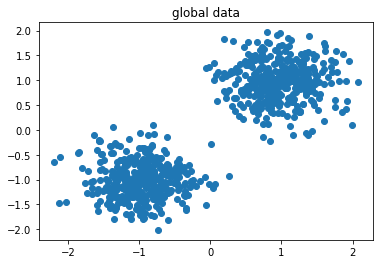

In [7]:
# centers = [[1, 1], [-1, -1], [1, -1]]
centers = [[1, 1], [-1, -1]]
# centers = [[1, 1, 1, 1], [-1, -1, -1, -1]]
spikes = [centers[0]]
total_no_samples = 750
cluster_std = 0.4
X, X_labels_true = make_blobs(n_samples=total_no_samples, n_features=2, 
                            centers=centers, 
                            cluster_std=cluster_std, random_state=0)
# X, labels_true = make_moons(n_samples=total_no_samples, noise=cluster_std, random_state=0)
ADM = euclidean_distances(X)

plt.scatter(X[:,0], X[:,1])
plt.title('global data')
plt.show()

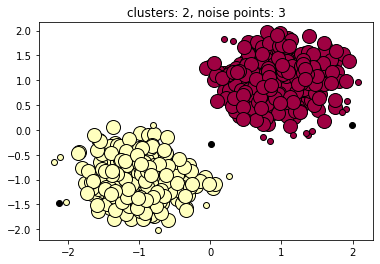

In [8]:
db = compute_db_clusters(ADM, eps=0.4, min_samples=10)
plot_db_clusters(db, savefig_name='global data clustered')

In [9]:
# D1_sample_size = random.randint(1, total_no_samples)
# D2_sample_size = total_no_samples - D1_sample_size
# print(f"D1_sample_size: {D1_sample_size}")
# print(f"D2_sample_size: {D2_sample_size}")
D1_sample_size = 350
D1 = X[:D1_sample_size]
D2 = X[D1_sample_size:]

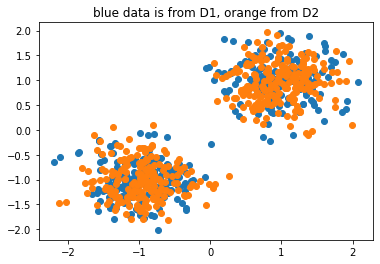

In [10]:
plt.scatter(D1[:,0], D1[:,1])
plt.scatter(D2[:,0], D2[:,1])
plt.title('blue data is from D1, orange from D2')
plt.show()

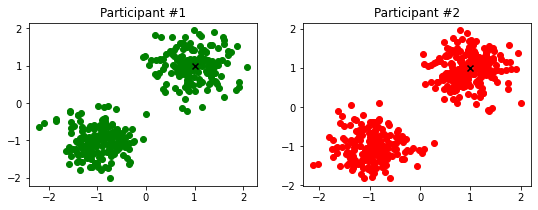

In [11]:
plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.scatter(D1[:,0], D1[:,1], c='g')
plt.scatter(spikes[0][0], spikes[0][1], c='black', marker='x')
plt.title('Participant #1')
plt.subplot(122)
plt.scatter(D2[:,0], D2[:,1], c='r')
plt.scatter(spikes[0][0], spikes[0][1], c='black', marker='x')
plt.title('Participant #2')
plt.show()

In [13]:
#### Participant Based Computation #### 
LSDM_D1 = euclidean_distances(D1, spikes)
LSDM_D2 = euclidean_distances(D2, spikes)


In [14]:
#### Coordinator Based Computation ####
LSDM_concat = np.concatenate([LSDM_D1, LSDM_D2])
FEDM = euclidean_distances(LSDM_concat)

In [29]:
pearson_adm_fedm = np.corrcoef(ADM.flatten(), FEDM.flatten())
spearman_adm_fedm = spearmanr(ADM.flatten(), FEDM.flatten())
print(f'Pearson coefficient: {pearson_adm_fedm[0,1]}')
print(f'Spearman coefficient: {spearman_adm_fedm.correlation}')

Pearson coefficient: 0.9340798110144467
Spearman coefficient: 0.879847011888208


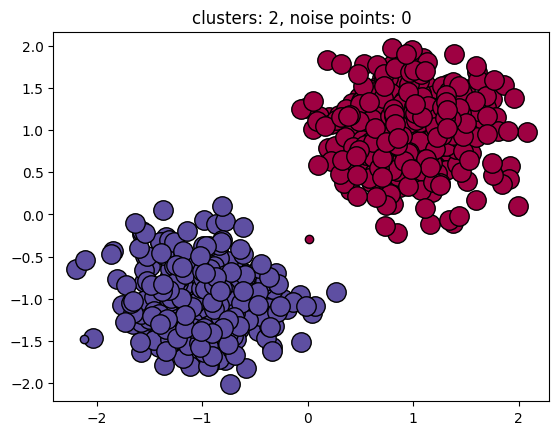

In [30]:
fedm_clustering = compute_db_clusters(FEDM, eps=0.4, min_samples=10)
plot_db_clusters(fedm_clustering, savefig_name='dbscan_fl')

In [31]:
print(evaluation(X_labels_true, fedm_clustering.labels_))

0.9986666666666667


In [32]:
print(evaluation(X_labels_true, db.labels_))

0.996
